# GPLVMs in Stan

Here we implement the *Bayesian Gaussian Process Latent Variable Model* for dimensionality reduction from [Titsias and Lawrence (2010)](http://proceedings.mlr.press/v9/titsias10a/titsias10a.pdf). We will be using `Stan` for inference of the posteriors of the latent variables.

TODO:
    - why are the CIs so large?
    - check bugs and implementation again. 
    - priors on kernel params and y noise.
    
**I do not take warranty for the correctness or completeness of this document.**

First we load some libraries and set some options.

In [1]:
library(rstan)
library(ggthemes)
library(kernlab)
library(MASS)
library(bayesplot)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘kernlab’

The following object is masked from ‘package:ggplot2’:

    alpha

This is bayesplot version 1.5.0
- Plotting theme set to bayesplot::theme_default()
- Online documentation at mc-stan.org/bayesplot


In [2]:
set.seed(23)
options(
    mc.cores = parallel::detectCores(), auto_write = TRUE,
    repr.plot.height=3, repr.plot.width=6)

Since inference using MCMC in `Stan` might take a while and because we want to be able to nicely visualize our results, we use a dimensionality of $1$ for features and latent variables.

In [3]:
n <- 100
p <- 1
q <- 1

First we create some *true* data against which we will test the GPLVM. $\mathbf{X}$ will be the matrix of *latent* features.

In [4]:
X <- matrix(rnorm(n * q), n, q)

We'll use a plain squared exponential kernel

$$
k(x, x') = \alpha^2 \exp\left( -\frac{1}{2\rho^2} ||x - x'||  \right)
$$

with $\alpha = 1$ and $\rho = 1$ as covariance of the GP prior. `kernlab` parameterizes this kernel differently (with one parameter only). Let's visualize this kernel for $K(x, 0)$.

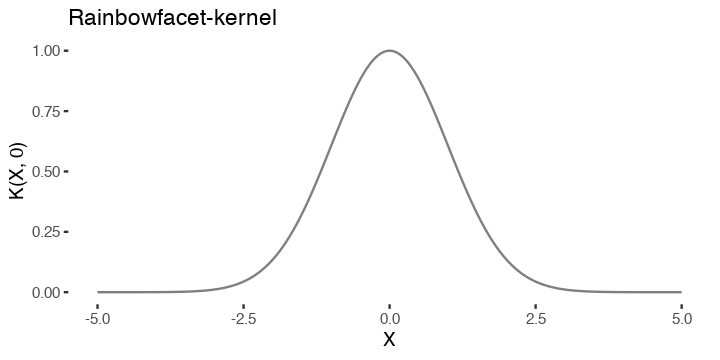

In [5]:
kernel_vis <- seq(-5, 5, length.out = 10000)
ggplot(data.frame(X=kernel_vis, K=kernelMatrix(rbfdot(0.5), kernel_vis, 0))) +
    geom_line(aes(X, K), alpha=.5) +
    theme_tufte() +
    scale_y_continuous("K(X, 0)") +
    scale_x_continuous("X") +
    ggtitle("Rainbowfacet-kernel")

We compute the kernel $\mathbf{K}$ with the parametrization from `kernlab` use it to draw some features from the Gaussian process to create the observed data $\mathbf{Y}$.

In [6]:
K <- kernelMatrix(rbfdot(0.5), X)

 We store the GP and the observed data in two matrices and set a variance of $\sigma^2 = 0.01$ to create the data.

In [7]:
var_y <- 0.01
Y <- matrix(0, n, p)
f <- matrix(0, n, p)
for (j in seq(p)) {
    f[, j] <- MASS::mvrnorm(1, rep(0, n), K)
    Y[, j] <- MASS::mvrnorm(1, f[, j], var_y * diag(n))
}

Let's see how the first feature looks like:

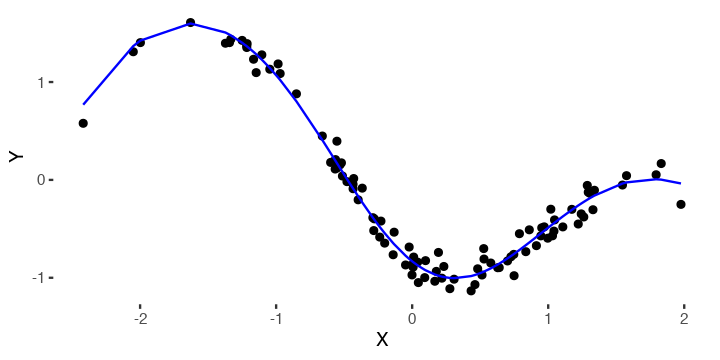

In [8]:
ggplot(data.frame(X=X[, 1], Y=Y[, 1]), f=f[, 1]) +
    geom_point(aes(X, Y)) +
    geom_line(aes(X, f), color="blue") +
    theme_tufte()

This is basically all we need for the GPLVM: the observational data $\mathbf{Y}$ and a kernel. The latent features $\mathbf{X}$, the kernel parameters, $\alpha$ and $\rho$, and the variance $\sigma^2$ is not know and needs to be estimated. The code block below show the Bayesian GPLVM in `Stan`. For the sake of demonstration, we do not put priors on the kernel parameters and the data variance, but just set it fixed. Thus we only put a prior on $\mathbf{X}$, such that

$$
x_{ij} \sim \mathcal{N}(0, 1).
$$

The prior is rather informative.

In [18]:
gplvm <- "
data {
    int<lower=1> n;
    int<lower=1> p;
    int<lower=1> q;
 
    real<lower=0> alpha_k;
    real<lower=0> rho_k;
    real<lower=0> var_y;

    matrix[n, p] Y;
}

parameters {
    row_vector[q] X[n];
}

model {
    matrix[n, n] K = cov_exp_quad(X, alpha_k, rho_k);

    for (i in 1:n)
        for (j in 1:q)
            X[i, j] ~ normal(0, 1);

    for (j in 1:q)
        Y[, j] ~ multi_normal(rep_vector(0, n), K + diag_matrix(rep_vector(var_y, n)));
}
"

In [19]:
simu_fit <- stan(model_code = gplvm,
                 data = list(Y = Y, n = n, p = p, q = q,
                             alpha_k = 1.0, rho_k = 1.0, var_y = var_y), 
                 iter = 1000)

In file included from file3e76416122b.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core.hpp:14:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core/matrix_vari.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat/fun/Eigen_NumTraits.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/prim/mat/fun/Eigen.hpp:

Finally let's plot the first 10 latent features.

'pars' not specified. Showing first 10 parameters by default.
ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


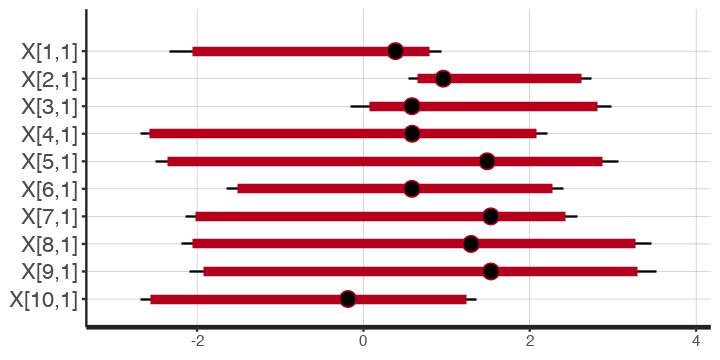

In [20]:
plot(simu_fit)